In [1]:
from __future__ import division, print_function

import netCDF4 as nc
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import glob
from geopy.distance import vincenty
from exceptions import KeyError
import gsw
%matplotlib inline

In [2]:
mesh = nc.Dataset('/mnt/storage0/jacquielee/research/data/Jasper/mesh_mask_anha4_201509.nc')
mask = mesh.variables['tmask'][0,:,:,:]
coordhgr = nc.Dataset('/mnt/storage0/xhu/ANHA4-I/ANHA4_mesh_hgr.nc')
coordzgr = nc.Dataset('/mnt/storage0/xhu/ANHA4-I/ANHA4_mesh_zgr.nc')
mesh = nc.Dataset('/mnt/storage0/xhu/ANHA4-I/mesh_mask_anha4_201509.nc')
grid = nc.Dataset('/mnt/storage0/xhu/ANHA4-I/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')

In [3]:
e1v = mesh.variables['e1v'][0,:,:]
e3v = mesh.variables['e3v'][0,:,:,:]
e2u = mesh.variables['e2u'][0,:,:]
e3u = mesh.variables['e3u'][0,:,:,:]
e1t= mesh.variables['e1t'][0,400:,:]  # dx
e2t= mesh.variables['e2t'][0,400:,:]  # dy 
e3t= mesh.variables['e3t'][0,:,400:,:]
tmask= mesh.variables['tmask'][0,:,400:,:]
dep = mesh.variables['gdept_0'][0,:]

In [4]:
H = coordzgr.variables['nav_lev']
bathy = grid.variables['Bathymetry'][:]
lat = np.array(grid.variables['nav_lat'])
lon = np.array(grid.variables['nav_lon'])
bathy = ma.masked_values(bathy[:],0)

In [5]:
#put in the coordinates for the individual areas of study
#Kara and Barenst Sea Corners
lats = lat
lons = lon
kbsc_lat = [lats[475,325],lats[675,325],lats[675,500],lats[475,500],lats[475,325]]
kbsc_lon = [lons[475,325],lons[675,325],lons[675,500],lons[475,500],lons[475,325]]

esls_lat = [lats[650,200],lats[799,200],lats[799,415],lats[650,415],lats[650,200]]
esls_lon = [lons[650,200],lons[799,200],lons[799,415],lons[650,415],lons[650,200]]

In [6]:
def density_flux(temp, sal):
    '''
    Calculates potential density anomoly
    '''

    density = gsw.sigma0(sal,temp)
    return density


def annual_trans(rangex,rangey, lat, lon, year, month=None):
    
   
    if month == None:
        nc_fileU=sorted(glob.glob('/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_y'+year+'m??d??_gridU.nc'))
        nc_fileV=sorted(glob.glob('/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_y'+year+'m??d??_gridV.nc'))
        nc_fileT=sorted(glob.glob('/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_y'+year+'m??d??_gridT.nc'))
    else:
        nc_fileU=sorted(glob.glob('/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_y'+year+'m'+month+'d??_gridU.nc'))
        nc_fileV=sorted(glob.glob('/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_y'+year+'m'+month+'d??_gridV.nc'))
        nc_fileT=sorted(glob.glob('/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_y'+year+'m'+month+'d??_gridT.nc')) 
    
    density_avg = np.zeros((50,rangey[1]-rangey[0],rangex[1]-rangex[0]))
    
    for filenum in range(0,len(nc_fileU)-1):
        print(filenum)
        sal = nc.Dataset(nc_fileT[filenum]).variables['vosaline'][0,:,rangey[0]:rangey[1],rangex[0]:rangex[1]]
        temp = nc.Dataset(nc_fileT[filenum]).variables['votemper'][0,:,rangey[0]:rangey[1],rangex[0]:rangex[1]]
        
        density = density_flux(temp, sal)
        
        density_avg = density_avg + density
        
    density_avg = density_avg/len(nc_fileT)
        
    return density_avg
def rho(SA, CT, p):
    """
    Calculates in-situ density from Absolute Salinity and Conservative
    Temperature, using the computationally-efficient 48-term expression for
    density in terms of SA, CT and p (McDougall et al., 2011).
    Parameters
    ----------
    SA : array_like
         Absolute Salinity  [g/kg]
    CT : array_like
         Conservative Temperature [:math:`^\circ` C (ITS-90)]
    p : array_like
        sea pressure [dbar]
    Returns
    -------
    rho : array_like
          in-situ density [kg/m**3]
    Notes
    -----
    The potential density with respect to reference pressure, pr, is obtained
    by calling this function with the pressure argument being pr (i.e.
    "rho(SA,CT,pr)").
    The 48-term equation has been fitted in a restricted range of parameter
    space, and is most accurate inside the "oceanographic funnel" described in
    McDougall et al. (2011).  The GSW library function "infunnel(SA,CT,p)" is
    available to be used if one wants to test if some of one's data lies
    outside this "funnel".
    Examples
    --------
    TODO
    References
    ----------
    .. [1] IOC, SCOR and IAPSO, 2010: The international thermodynamic equation
       of seawater - 2010: Calculation and use of thermodynamic properties.
       Intergovernmental Oceanographic Commission, Manuals and Guides No. 56,
       UNESCO (English), 196 pp. See appendix A.20 and appendix K.
    .. [2] McDougall T.J., P.M. Barker, R. Feistel and D.R. Jackett, 2011:  A
       computationally efficient 48-term expression for the density of
       seawater in terms of Conservative Temperature, and related properties
       of seawater.
    """

    SA = np.maximum(SA, 0)
    sqrtSA = np.sqrt(SA)
    args = SA, CT, p, sqrtSA

    # This function calculates rho using the computationally-efficient 48-term
    # expression for density in terms of SA, CT and p. If one wanted to compute
    # rho from SA, CT, and p with the full TEOS-10 Gibbs function, the following
    # lines of code will enable this.
    #
    # pt0 = pt_from_CT(SA, CT)
    # t = pt_from_t(SA, pt0, 0, p)
    # rho = rho_t_exact(SA, t, p)
    #
    # or call the following, it is identical to the lines above.
    #
    # rho = rho_CT_exact(SA, CT, p)
    #
    # or call the following, it is identical to the lines above.
    #
    # rho,_ ,_ = rho_alpha_beta_CT_exact(SA, CT, p)

    return v_hat_denominator(*args) / v_hat_numerator(*args)

v01 = 9.998420897506056e+2
v02 = 2.839940833161907
v03 = -3.147759265588511e-2
v04 = 1.181805545074306e-3
v05 = -6.698001071123802
v06 = -2.986498947203215e-2
v07 = 2.327859407479162e-4
v08 = -3.988822378968490e-2
v09 = 5.095422573880500e-4
v10 = -1.426984671633621e-5
v11 = 1.645039373682922e-7
v12 = -2.233269627352527e-2
v13 = -3.436090079851880e-4
v14 = 3.726050720345733e-6
v15 = -1.806789763745328e-4
v16 = 6.876837219536232e-7
v17 = -3.087032500374211e-7
v18 = -1.988366587925593e-8
v19 = -1.061519070296458e-11
v20 = 1.550932729220080e-10
v21 = 1.0
v22 = 2.775927747785646e-3
v23 = -2.349607444135925e-5
v24 = 1.119513357486743e-6
v25 = 6.743689325042773e-10
v26 = -7.521448093615448e-3
v27 = -2.764306979894411e-5
v28 = 1.262937315098546e-7
v29 = 9.527875081696435e-10
v30 = -1.811147201949891e-11
v31 = -3.303308871386421e-5
v32 = 3.801564588876298e-7
v33 = -7.672876869259043e-9
v34 = -4.634182341116144e-11
v35 = 2.681097235569143e-12
v36 = 5.419326551148740e-6
v37 = -2.742185394906099e-5
v38 = -3.212746477974189e-7
v39 = 3.191413910561627e-9
v40 = -1.931012931541776e-12
v41 = -1.105097577149576e-7
v42 = 6.211426728363857e-10
v43 = -1.119011592875110e-10
v44 = -1.941660213148725e-11
v45 = -1.864826425365600e-14
v46 = 1.119522344879478e-14
v47 = -1.200507748551599e-15
v48 = 6.057902487546866e-17

def v_hat_denominator(SA, CT, p, sqrtSA):
    return (v01 + CT * (v02 + CT * (v03 + v04*CT)) +
            SA *
            (v05 + CT * (v06 + v07 * CT) + sqrtSA *
             (v08 + CT * (v09 + CT * (v10 + v11 * CT)))) +
            p *
            (v12 + CT * (v13 + v14 * CT) + SA * (v15 + v16 * CT) +
             p * (v17 + CT * (v18 + v19 * CT) + v20 * SA)))


def v_hat_numerator(SA, CT, p, sqrtSA):
    return (v21 + CT * (v22 + CT * (v23 + CT * (v24 + v25 * CT))) +
            SA *
            (v26 + CT * (v27 + CT * (v28 + CT * (v29 + v30 * CT))) +
             v36 * SA + sqrtSA *
             (v31 + CT * (v32 + CT * (v33 + CT * (v34 + v35 * CT))))) +
            p *
            (v37 + CT * (v38 + CT * (v39 + v40 * CT)) + SA *
             (v41 + v42 * CT) + p *
             (v43 + CT * (v44 + v45 * CT + v46 * SA) + p * (v47 + v48 * CT))))

In [7]:
rangex = [325,500]
rangey = [475,675]

density10_01 = annual_trans(rangex,rangey,lat,lon,'2010','01')

0
1
2
3
4


(array([ 19902.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   2098.]),
 array([   0.        ,   85.63523763,  171.27047526,  256.90571289,
         342.54095052,  428.17618815,  513.81142578,  599.44666341,
         685.08190104,  770.71713867,  856.3523763 ]),
 <a list of 10 Patch objects>)

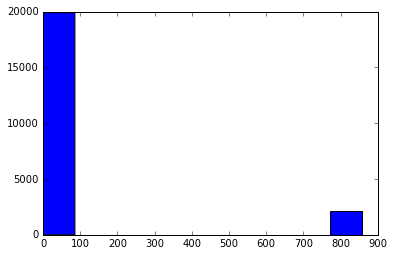

In [26]:
#density = ma.masked_where(density10_01[:,:,:] < 10.0, density10_01[:])
plt.hist(density10_01[3:47,10:20, 100:150].flatten())


In [30]:
print(density10_01[3:47,10:20, 100:150])

[[[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [22.789149789816975 22.785903309080407 22.783894341781092 ..., -- -- --]
  [22.79317153540478 22.79090500410852 22.786001529436362 ..., -- -- --]
  [22.79240591149062 22.790310021121172 22.785937888564376 ..., -- --
   21.024045521554854]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [22.789156582662866 22.785902990472852 22.783893612518415 ..., -- -- --]
  [22.793170905173156 22.790903843730614 22.786000393671657 ..., -- -- --]
  [22.792404822103247 22.79030891158398 22.785937237584903 ..., -- --
   21.040497361895877]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [22.78916340804945 22.785902908143765 22.78389232362353 ..., -- -- --]
  [22.793169734670226 22.7909031292736 22.785999693116576 ..., -- -- --]
  [22.792403192771605 22.79030774976813 22.78593551621164 ..., -- --
   21.0586166871949]]

 ..., 
